In [1]:
#pip install scikit-learn pandas seaborn

In [2]:
import sklearn as sk
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Part A. Linear Regression From Scratch

Creating dataframes for the targets and features

In [3]:
X = pd.DataFrame(fetch_california_housing()['data'], columns=fetch_california_housing()['feature_names'])
y = pd.DataFrame(fetch_california_housing()['target'], columns=fetch_california_housing()['target_names'])

Reviewing the data

In [4]:
display(X.info())
display(y.info())
print('There are no missings')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedHouseVal  20640 non-null  float64
dtypes: float64(1)
memory usage: 161.4 KB


None

There are no missings


In [5]:
display(X.describe())
display(y.describe())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


,MedHouseVal
count,20640.000000
mean,2.068558
std,1.153956
min,0.149990
25%,1.196000
50%,1.797000
75%,2.647250
max,5.000010


There are not ouliers


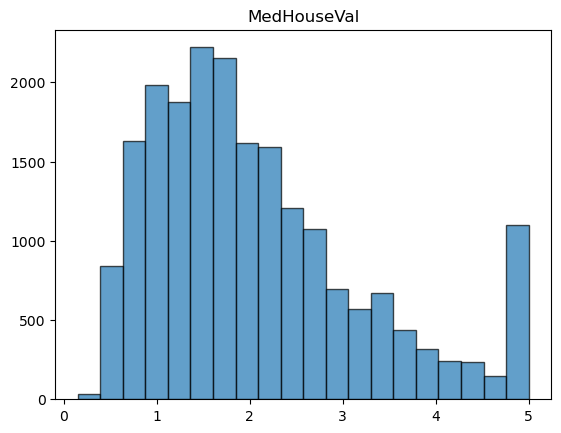

In [6]:
plt.hist(y['MedHouseVal'], bins=20, edgecolor='black', alpha=0.7) 
plt.title('MedHouseVal')
plt.show
print('There are not ouliers')

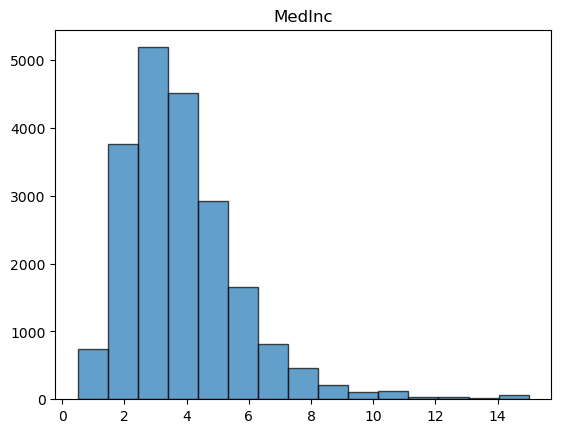

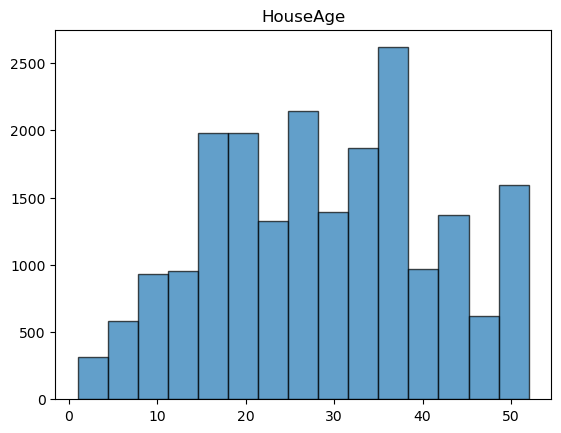

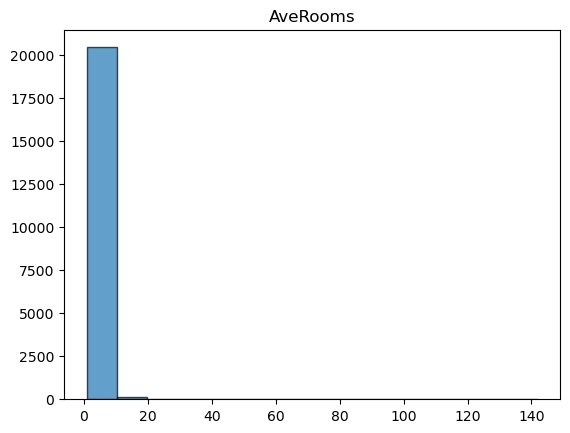

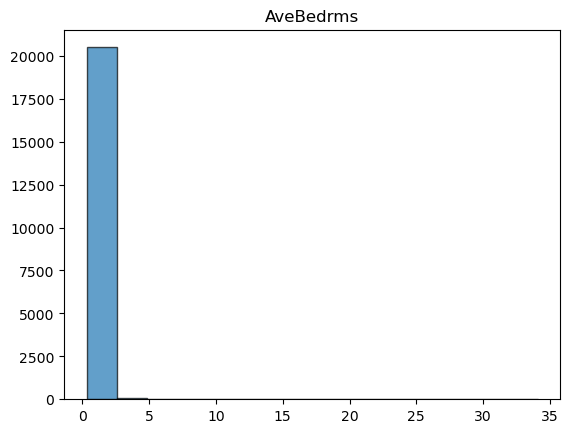

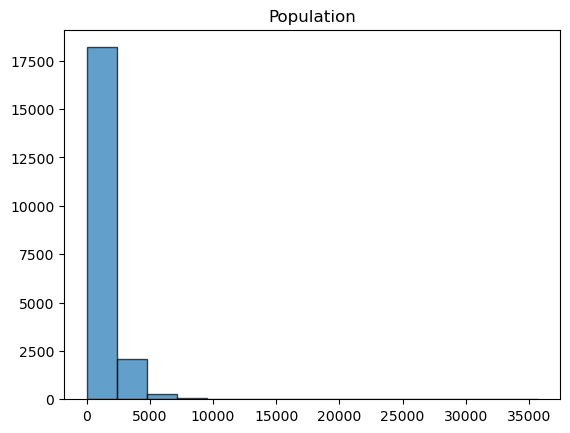

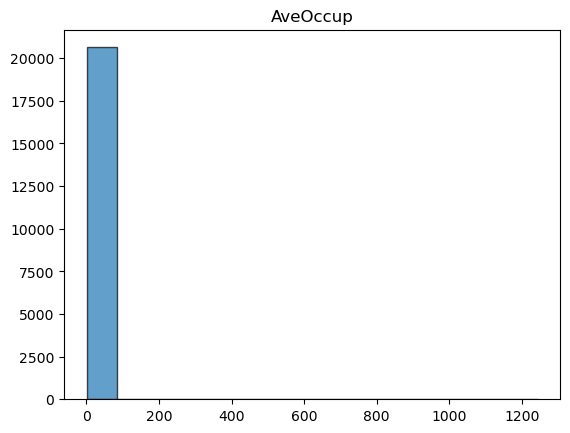

In [7]:
for target in ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']:
    plt.hist(X[target], bins=15, edgecolor='black', alpha=0.7)
    plt.title(target)
    plt.show()

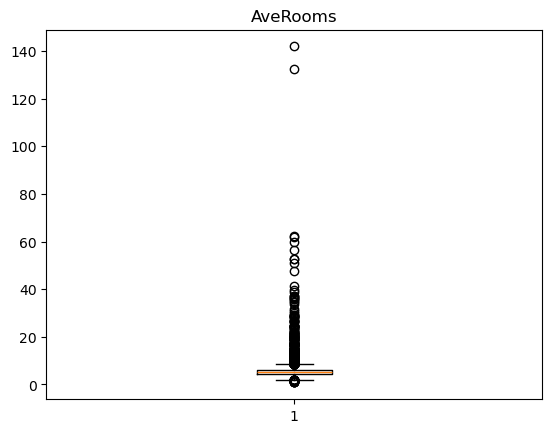

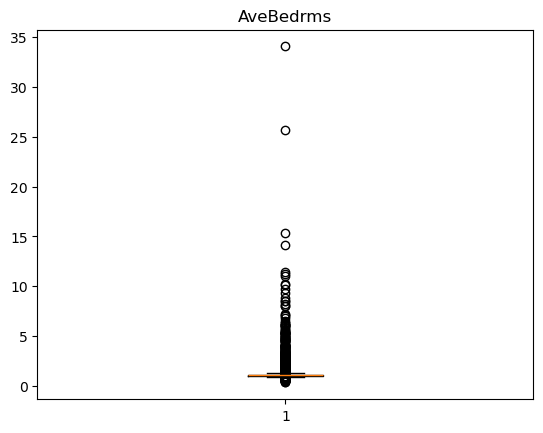

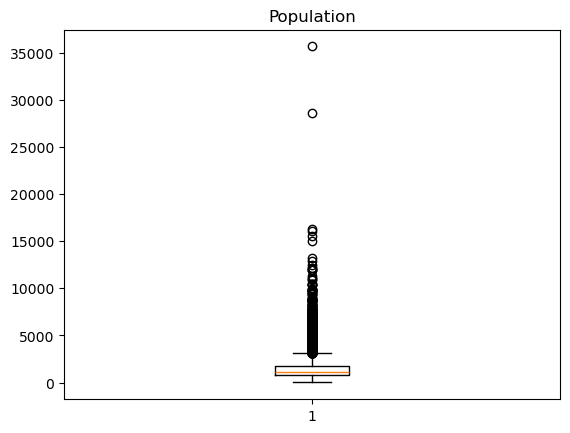

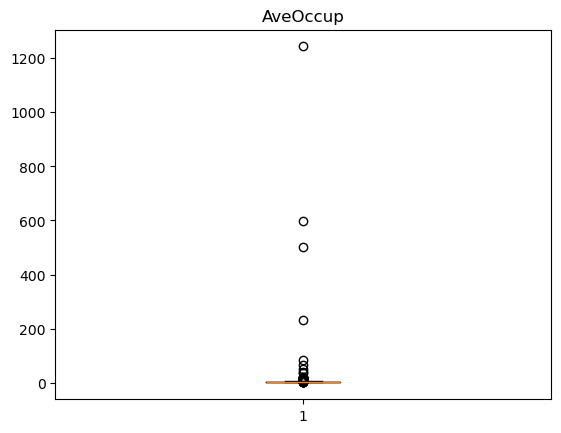

In [8]:
for target in ['AveRooms', 'AveBedrms', 'Population', 'AveOccup']:
    plt.boxplot(X[target])
    plt.title(target)
    plt.show()

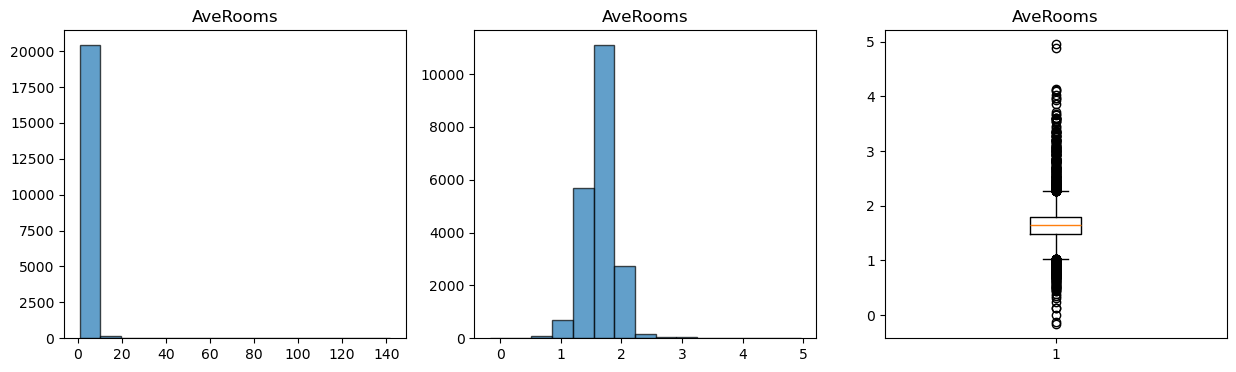

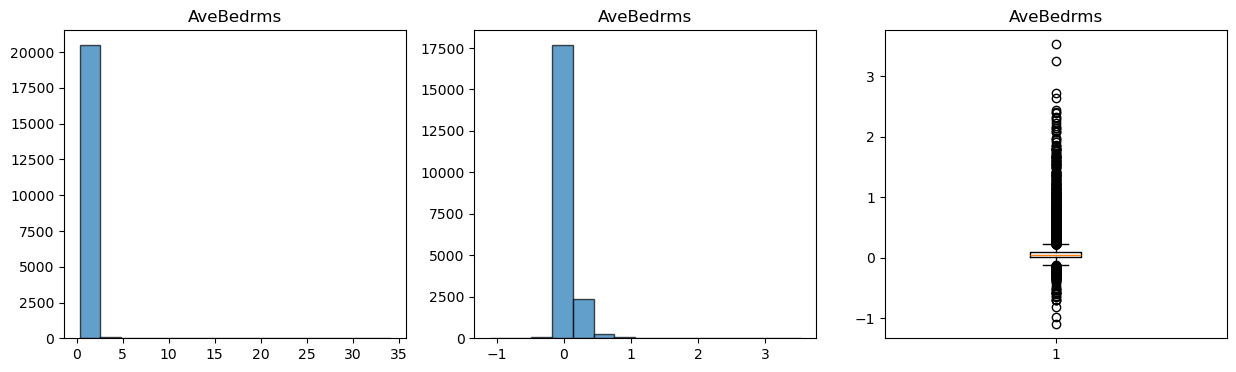

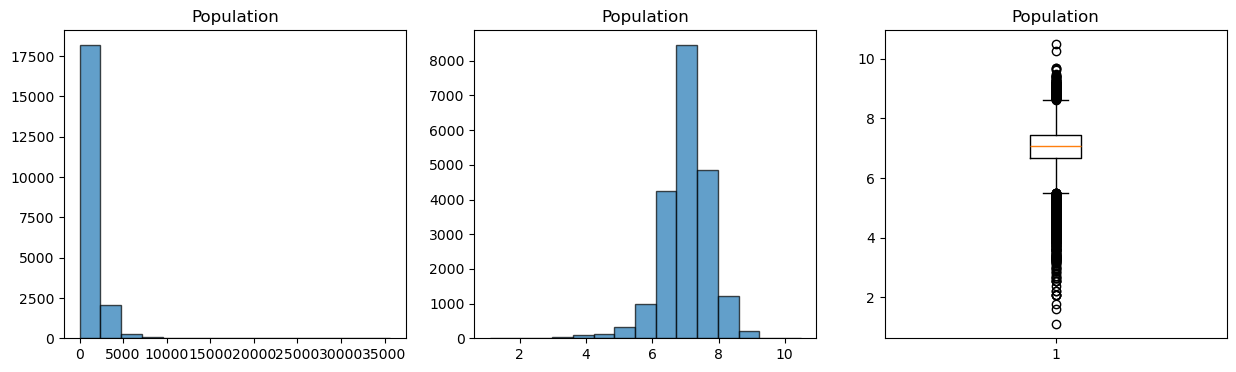

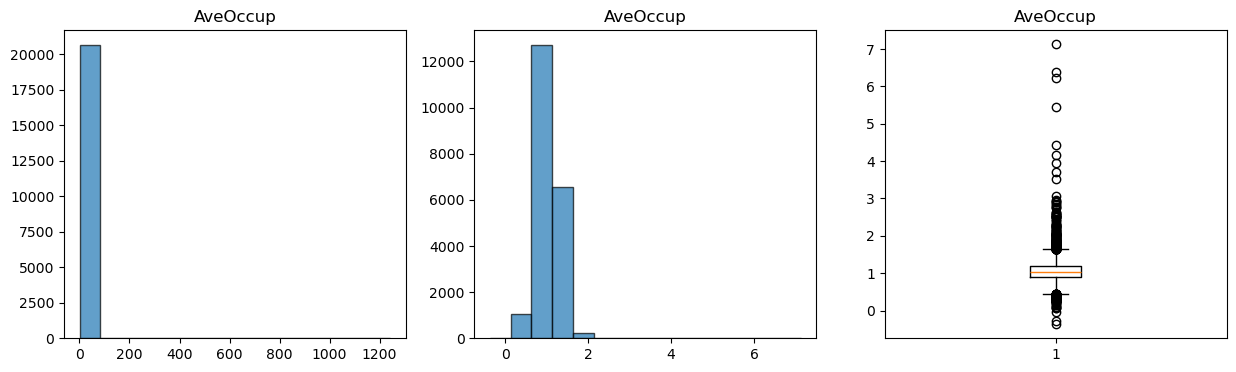

In [9]:
for target in ['AveRooms', 'AveBedrms', 'Population', 'AveOccup']:
    fig, axs = plt.subplots(1, 3, figsize=(15, 4)) 
    axs[0].hist(X[target], bins=15, edgecolor='black', alpha=0.7)
    axs[0].set_title(target)
    axs[1].hist(np.log(X[target]), bins=15, edgecolor='black', alpha=0.7)
    axs[1].set_title(target)
    axs[2].boxplot(np.log(X[target]))
    axs[2].set_title(target)
    plt.show()

In [10]:
df = X.copy()

o_rows = len(df)

print(o_rows)

for feature in ['AveRooms', 'AveBedrms', 'Population', 'AveOccup']:
    q1 = np.percentile(np.log(df[feature]), 25)
    q3 = np.percentile(np.log(df[feature]), 75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df = df[(np.log(df[feature])<upper_bound) & (np.log(df[feature])>lower_bound)]

    print(len(df))

#    fig, axs = plt.subplots(1, 3, figsize=(15, 4)) 
#    axs[0].hist(X[target],

m_rows = len(df)

print(m_rows)

print(f'The dataset ends with {np.round(m_rows/o_rows,2)}% of the original rows')

X_mod = df
y_mod = X_mod.join(y, how='inner', lsuffix='_del')[['MedHouseVal']]

20640
20069
18915
18295
17889
17889
The dataset ends with 0.87% of the original rows


Vizualiting correlations

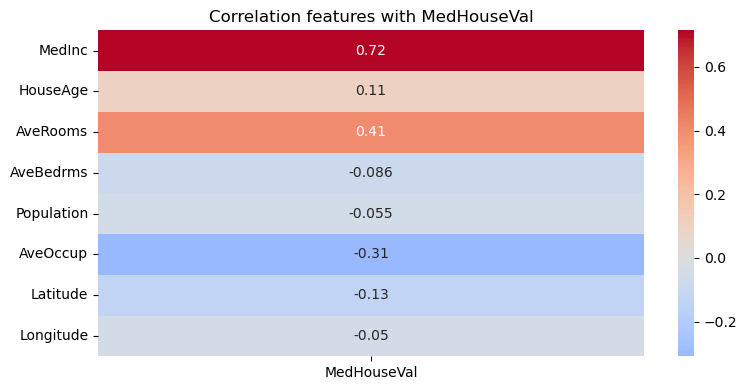

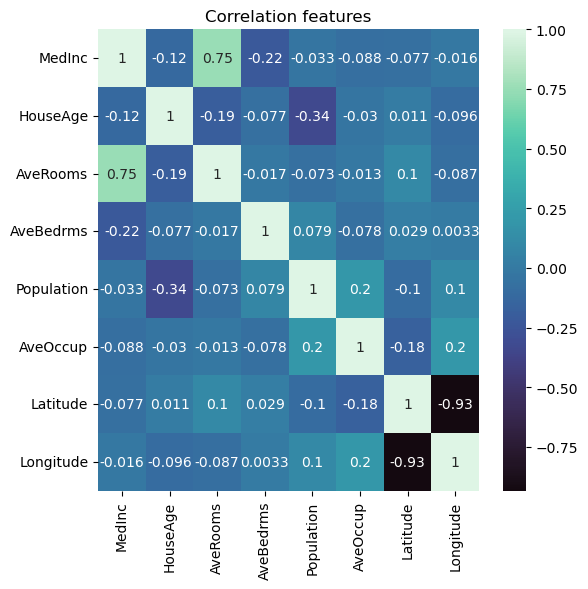

Longitude, Population and AveBedrms are discarted for the poor correlation with the target. Surprisingly Latitude have a minimun correlation whit MedHouseVal


In [11]:
df_combined = pd.concat([X_mod, y_mod], axis=1)


corr_matrix = df_combined.corr()
target_col = y_mod.columns[0]
corr_with_target = corr_matrix[[target_col]].drop(index=target_col)
corr_features = X_mod.corr()


plt.figure(figsize=(8, len(corr_with_target) * 0.5))
sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', center=0)
plt.title(f'Correlation features with {target_col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
sns.heatmap(corr_features, annot=True, cmap='mako', center=0)
plt.title(f'Correlation features')
plt.tight_layout()
plt.show()

print('Longitude, Population and AveBedrms are discarted for the poor correlation with the target. Surprisingly Latitude have a minimun correlation whit MedHouseVal')

X_mod_2 = X_mod[['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude']]

Standardizing features

In [12]:
X_std = X_mod_2.copy()
for feature in X_std.columns:
    X_std[feature] = (X_std[feature] - np.mean(X_std[feature])) / np.std(X_std[feature])


Spliting the dataset in train and test data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y_mod, test_size=0.2, random_state=1234)
print('We are ready!')

We are ready!


Closed-form OLS

In [14]:
X_train_wi = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
beta_hat = np.linalg.inv(X_train_wi.T @ X_train_wi) @ X_train_wi.T @ y_train

In [15]:
for i, f in enumerate(['Intercept'] + [i for i in X_train.columns]):
    print(f'Coefficient of {f}: {beta_hat.iloc[i,:][0]}')

Coefficient of Intercept: 2.092596914039605
Coefficient of MedInc: 0.9817802957274003
Coefficient of HouseAge: 0.19612252783354886
Coefficient of AveRooms: -0.2309601404535895
Coefficient of AveOccup: -0.28576924155559474
Coefficient of Latitude: -0.10779950099741081


C:\Users\aula02\AppData\Local\Temp\ipykernel_9028\3449843306.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Coefficient of {f}: {beta_hat.iloc[i,:][0]}')


In [16]:
y_train_pred = X_train_wi @ beta_hat

In [17]:
X_test_wi = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

In [18]:
y_test_pred = X_test_wi @ beta_hat

In [19]:
e = y_test_pred - y_test.reset_index(drop=True)

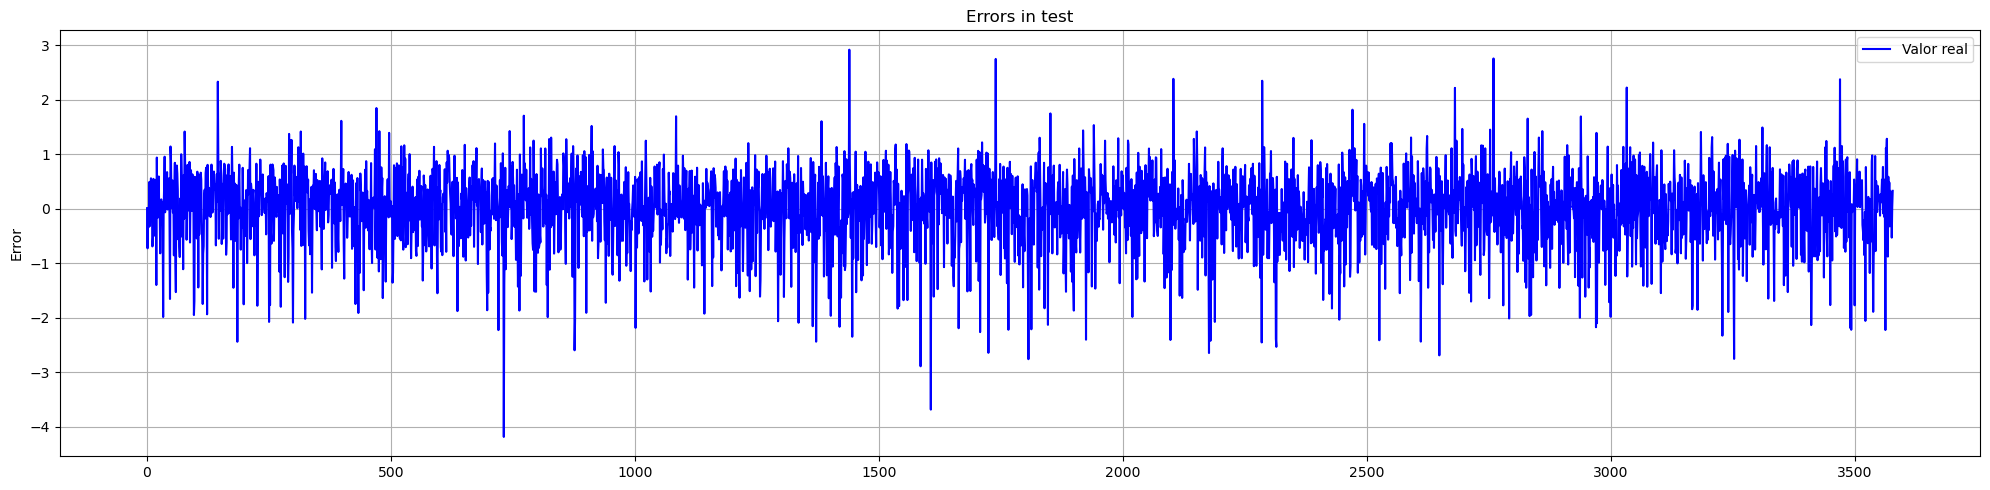

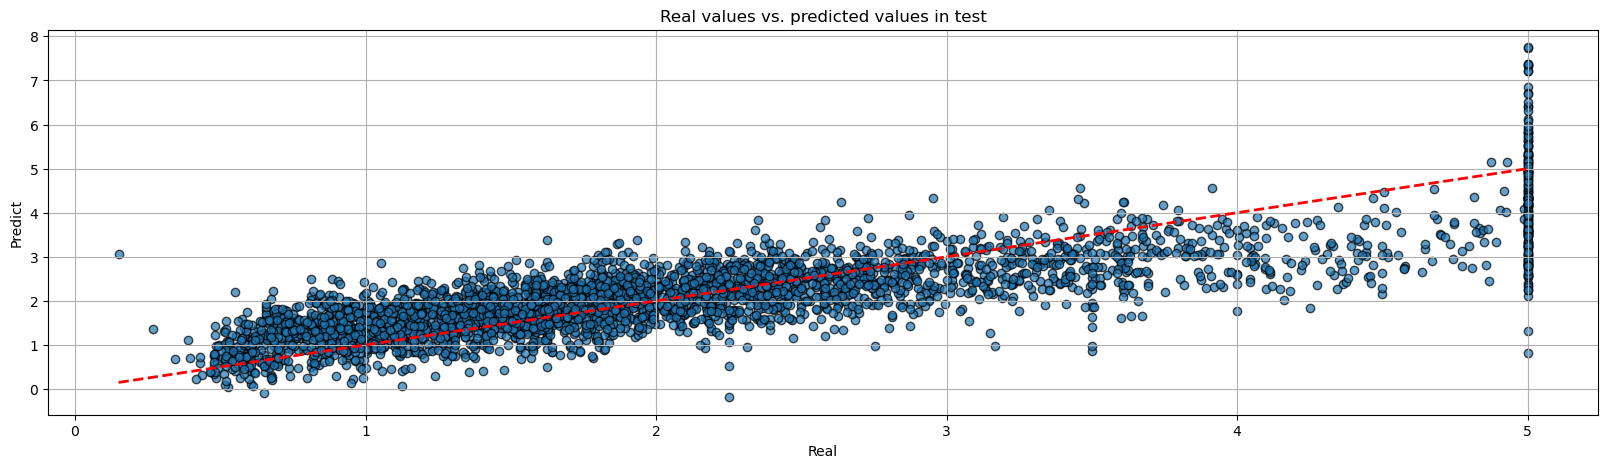

In [20]:
x = range(len(y_test_pred))
plt.figure(figsize=(20, 5))
plt.plot(e, label='Valor real', color='blue')
#plt.plot(x, y_test, label='Valor real', color='red')
plt.ylabel('Error')
plt.title('Errors in test')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,5))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)

plt.xlabel('Real')
plt.ylabel('Predict')
plt.title('Real values vs. predicted values in test')
plt.grid(True)
plt.show()

Now with gradient descent

In [21]:
def f(X, beta):
    return X @ beta
def mse_gradient(beta, X, y):
    return np.mean((f(X, beta) - y) * X.T, axis=1)
def mean_squared_error(beta, X, y):
    return np.mean((y-f(X, beta))**2)

In [22]:
threshold = 1e-3
step_size = 9e-1
beta, beta_prev = np.array([10,10,10,10,5,5]), np.ones(6,)
opt_pts = [beta]
opt_grads = []
iter = 0

ls_cost_1 = []
ls_iter_1 = []

X = X_train
X['Coefficient'] = 1
cols = ['Coefficient'] + [col for col in X.columns if col != 'Coefficient']
X = X[cols]
y = y_train['MedHouseVal']

while np.linalg.norm(beta - beta_prev) > threshold:
    ls_iter_1.append(iter)
    cost = mean_squared_error(beta, X, y)
    ls_cost_1.append(cost)
    if iter % 10 == 0:
        print('Iteration %d. MSE: %.6f' % (iter, cost))
    beta_prev = beta
    gradient = mse_gradient(beta, X, y)
    beta = beta_prev - step_size * gradient
    opt_pts += [beta]
    opt_grads += [gradient]
    iter += 1

print(beta)

Iteration 0. MSE: 458.537905
Iteration 10. MSE: 0.485643
Iteration 20. MSE: 0.469625
Coefficient    2.092593
MedInc         0.982259
HouseAge       0.196011
AveRooms      -0.230976
AveOccup      -0.285757
Latitude      -0.107723
dtype: float64


In [23]:
threshold = 1e-3
step_size = 4e-1
beta, beta_prev = np.array([10,10,10,10,5,5]), np.ones(6,)
opt_pts = [beta]
opt_grads = []
iter = 0

ls_cost_0 = []
ls_iter_0 = []

X = X_train
X['Coefficient'] = 1
cols = ['Coefficient'] + [col for col in X.columns if col != 'Coefficient']
X = X[cols]
y = y_train['MedHouseVal']

while np.linalg.norm(beta - beta_prev) > threshold:
    ls_iter_0.append(iter)
    cost = mean_squared_error(beta, X, y)
    ls_cost_0.append(cost)
    if iter % 10 == 0:
        print('Iteration %d. MSE: %.6f' % (iter, cost))
    beta_prev = beta
    gradient = mse_gradient(beta, X, y)
    beta = beta_prev - step_size * gradient
    opt_pts += [beta]
    opt_grads += [gradient]
    iter += 1

print(beta)

Iteration 0. MSE: 458.537905
Iteration 10. MSE: 0.506269
Iteration 20. MSE: 0.469641
Coefficient    2.092683
MedInc         0.985667
HouseAge       0.196403
AveRooms      -0.234577
AveOccup      -0.284295
Latitude      -0.106083
dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

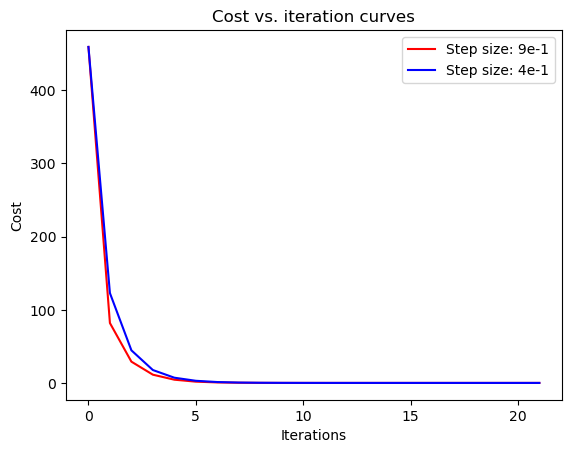

In [24]:
plt.plot(ls_iter_1,ls_cost_1, color='red', label='Step size: 9e-1')
plt.plot(ls_iter_0,ls_cost_0, color='blue', label='Step size: 4e-1')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. iteration curves')
plt.legend()
plt.show

Comparing error and parameters

In [25]:
print('With gradient descent:')
display(beta)
print('With closed-form OLS:')
display(beta_hat)
print('Really close values')

With gradient descent:


Coefficient    2.092683
MedInc         0.985667
HouseAge       0.196403
AveRooms      -0.234577
AveOccup      -0.284295
Latitude      -0.106083
dtype: float64

With closed-form OLS:


,MedHouseVal
0,2.092597
1,0.981780
2,0.196123
3,-0.230960
4,-0.285769
5,-0.107800


Really close values


In [26]:
X_test_eval = X_test
X_test_eval['Coefficient'] = 1
cols = ['Coefficient'] + [col for col in X_test_eval.columns if col != 'Coefficient']
X_test_eval = X_test_eval[cols]
y_test_eval = y_test['MedHouseVal']

In [27]:
print('Error with gradient descent')
display(mean_squared_error(beta, X_test_eval, y_test_eval))
print('Error with closed-form OLS:')
display(np.mean((y_test.to_numpy()-y_test_pred.to_numpy())**2))
print('Again, really close values')

Error with gradient descent


0.4714541100800189

Error with closed-form OLS:


0.4714684819568809

Again, really close values


# Part B. Scikit-learn Linear Models

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
linear_model = LinearRegression()
linear_model.fit(X, y)
train_mse = ((y - linear_model.predict(X)) ** 2).mean()
print('Train error: %.4f' % train_mse)
training_R2 = 1 - train_mse / ((y - y.mean()) ** 2).mean()
print('Train R2: %.4f' % training_R2)

Train error: 0.4696
Train R2: 0.6387


In [30]:
test_mse = ((y_test_eval - linear_model.predict(X_test_eval)) ** 2).mean()
print('Test error: %.4f' % test_mse)
testing_R2 = 1 - test_mse / ((y_test_eval - y_test_eval.mean()) ** 2).mean()
print('Test R2: %.4f' % testing_R2)

Test error: 0.4715
Test R2: 0.6431


# Part C. Regularization and Hyperparameter Choice

In [31]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import ShuffleSplit, KFold
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

(-3999.9989499999997, 83999.99995, -0.40468754221752046, 2.2115150680357605)

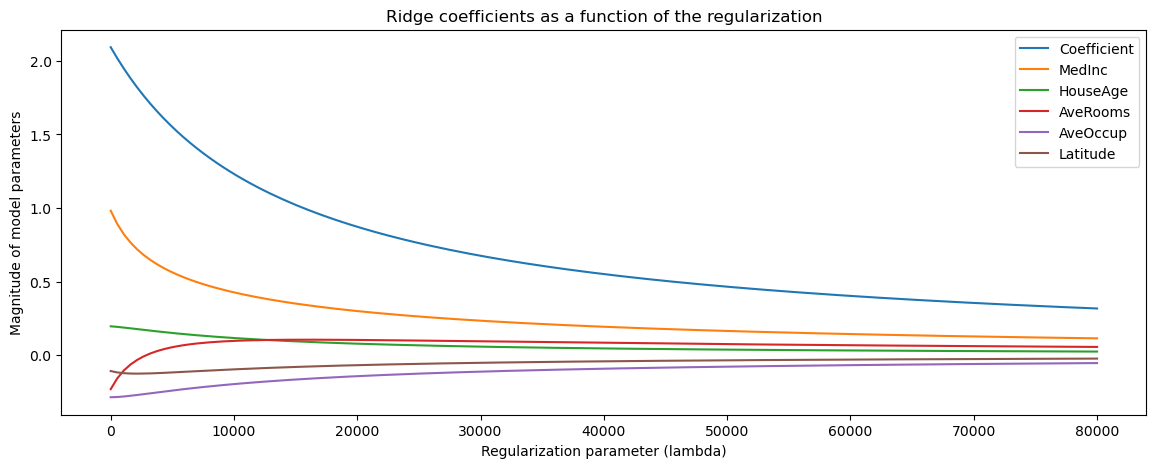

In [33]:
alphas = np.linspace(1e-3,8e4, # Used more than 1e2 in order to see effects
                     150)
ridge_coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    ridge_coefs.append(ridge.coef_)

# plot ridge coefficients
plt.figure(figsize=(14, 5))
plt.plot(alphas, ridge_coefs)
plt.xlabel('Regularization parameter (lambda)')
plt.ylabel('Magnitude of model parameters')
plt.title('Ridge coefficients as a function of the regularization')
plt.legend([c for c in X.columns])
plt.axis('tight')

(-0.14895, 3.14995, -0.4038350301587034, 2.2104283992792437)

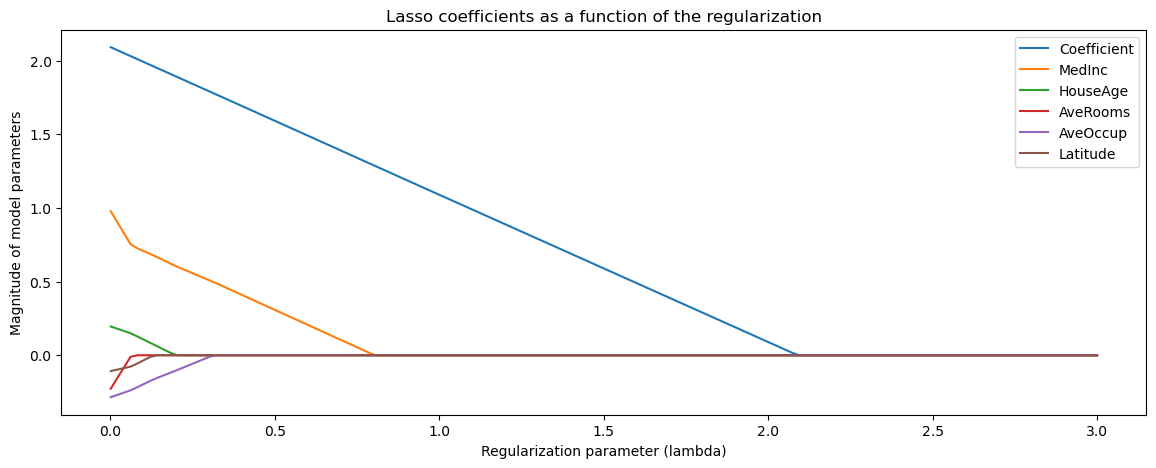

In [34]:
alphas = np.linspace(1e-3,3, # Used more than 1e2 in order to see effects
                     150)
lasso_coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False)
    lasso.fit(X, y)
    lasso_coefs.append(lasso.coef_)

# plot ridge coefficients
plt.figure(figsize=(14, 5))
plt.plot(alphas, lasso_coefs)
plt.xlabel('Regularization parameter (lambda)')
plt.ylabel('Magnitude of model parameters')
plt.title('Lasso coefficients as a function of the regularization')
plt.legend([c for c in X.columns])
plt.axis('tight')

In [35]:
print('As expected, the coefficients that become 0 first are the one related to the less correlated features with the target')

As expected, the coefficients that become 0 first are the one related to the less correlated features with the target


In [43]:
alphas = np.linspace(1e-3,3, 150)

K = 5
kfold = KFold(K,
                  random_state=0,
                  shuffle=True)

In [ ]:
ridge_scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X, y, cv=kfold, scoring='neg_mean_squared_error')
    ridge_scores.append(np.mean(scores))

i = np.argmax(ridge_scores)

best_alpha_ridge = alphas[i]

print(f'Best alpha for Ridge: {best_alpha_ridge}')

Best alpha for Ridge: 2.054006711409396


In [ ]:
lasso_scores = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    scores = cross_val_score(lasso, X, y, cv=kfold, scoring='neg_mean_squared_error')
    lasso_scores.append(np.mean(scores))

i = np.argmax(lasso_scores)

best_alpha_lasso = alphas[i]

print(f'Best alpha for Lasso: {best_alpha_lasso}')

Best alpha for Lasso: 0.001


In [ ]:
ridgeCV = ElasticNetCV(alphas=alphas,
                           l1_ratio=0,
                           cv=kfold,
                           max_iter=1000)
ridgeCV.fit(X,y)

best_alpha_ridgeCV = ridgeCV.alpha_

mse_path_ridgeCV = ridgeCV.mse_path_
mean_errors_ridgeCV = mse_path_ridgeCV.mean(axis=1)
best_error_ridgeCV = mean_errors_ridgeCV[np.where(ridgeCV.alphas == best_alpha_ridgeCV)[0][0]]

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6103.339873101307, tolerance: 1.4799744269633575
  model = cd_fast.enet_coordinate_descent_gram(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: O

Best error with ridgeCV: 0.9144013170428271


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.369e+03, tolerance: 1.860e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [61]:
lassoCV = ElasticNetCV(alphas=alphas,
                           l1_ratio=1,
                           cv=kfold)
lassoCV.fit(X,y)

best_alpha_lassoCV = lassoCV.alpha_

mse_path_lassoCV = lassoCV.mse_path_
mean_errors_lassoCV = mse_path_lassoCV.mean(axis=1)
best_error_lassoCV = mean_errors_lassoCV[np.where(lassoCV.alphas == best_alpha_lassoCV)[0][0]]

In [64]:
print('Best error with lassoCV:', best_error_lassoCV)
print('Best error with ridgeCV:', best_error_ridgeCV)
print('We have a minor error in lasso with cross_val_score and a minor one with ridgeCV in ridge')

Best error with lassoCV: 1.29988339725027
Best error with ridgeCV: 0.9144013170428271
We have a minor error in lasso with cross_val_score and a minor one with ridgeCV in ridge


Adding polinomial feature

In [65]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [67]:
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)

In [ ]:
linear_regression = LinearRegression()
pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
pipeline.fit(X, y)

In [72]:
lassoCV = ElasticNetCV(alphas=alphas,
                           l1_ratio=1,
                           cv=kfold)
pipeline = Pipeline([("pf", polynomial_features), ("lCV", lassoCV)])
# After fitting the pipeline
pipeline.fit(X, y)

# Access the fitted ElasticNetCV model
lassoCV_fitted = pipeline.named_steps["lCV"]

# Best alpha
best_alpha = lassoCV_fitted.alpha_

# Mean squared error path: shape (n_alphas, n_folds)
mse_path = lassoCV_fitted.mse_path_

# Mean error per alpha
mean_errors = mse_path.mean(axis=1)

# Error corresponding to best alpha
best_error = mean_errors[np.where(lassoCV_fitted.alphas == best_alpha)[0][0]]

print(f"Best alpha: {best_alpha}")
print(f"Cross-validated error at best alpha: {best_error:.4f}")


Best alpha: 0.001
Cross-validated error at best alpha: 1.2999


In [71]:
pipeline['lCV']

ElasticNetCV(alphas=array([1.00000000e-03, 2.11275168e-02, 4.12550336e-02, 6.13825503e-02,
       8.15100671e-02, 1.01637584e-01, 1.21765101e-01, 1.41892617e-01,
       1.62020134e-01, 1.82147651e-01, 2.02275168e-01, 2.22402685e-01,
       2.42530201e-01, 2.62657718e-01, 2.82785235e-01, 3.02912752e-01,
       3.23040268e-01, 3.43167785e-01, 3.63295302e-01, 3.83422819e-01,
       4.03550336e-01, 4.236778...
       2.57732215e+00, 2.59744966e+00, 2.61757718e+00, 2.63770470e+00,
       2.65783221e+00, 2.67795973e+00, 2.69808725e+00, 2.71821477e+00,
       2.73834228e+00, 2.75846980e+00, 2.77859732e+00, 2.79872483e+00,
       2.81885235e+00, 2.83897987e+00, 2.85910738e+00, 2.87923490e+00,
       2.89936242e+00, 2.91948993e+00, 2.93961745e+00, 2.95974497e+00,
       2.97987248e+00, 3.00000000e+00]),
             cv=KFold(n_splits=5, random_state=0, shuffle=True), l1_ratio=1)

In [70]:
pipeline.named_steps["lCV"]

ElasticNetCV(alphas=array([1.00000000e-03, 2.11275168e-02, 4.12550336e-02, 6.13825503e-02,
       8.15100671e-02, 1.01637584e-01, 1.21765101e-01, 1.41892617e-01,
       1.62020134e-01, 1.82147651e-01, 2.02275168e-01, 2.22402685e-01,
       2.42530201e-01, 2.62657718e-01, 2.82785235e-01, 3.02912752e-01,
       3.23040268e-01, 3.43167785e-01, 3.63295302e-01, 3.83422819e-01,
       4.03550336e-01, 4.236778...
       2.57732215e+00, 2.59744966e+00, 2.61757718e+00, 2.63770470e+00,
       2.65783221e+00, 2.67795973e+00, 2.69808725e+00, 2.71821477e+00,
       2.73834228e+00, 2.75846980e+00, 2.77859732e+00, 2.79872483e+00,
       2.81885235e+00, 2.83897987e+00, 2.85910738e+00, 2.87923490e+00,
       2.89936242e+00, 2.91948993e+00, 2.93961745e+00, 2.95974497e+00,
       2.97987248e+00, 3.00000000e+00]),
             cv=KFold(n_splits=5, random_state=0, shuffle=True), l1_ratio=1)

In [ ]:
best_alpha_lassoCV = lassoCV.alpha_

mse_path_lassoCV = lassoCV.mse_path_
mean_errors_lassoCV = mse_path_lassoCV.mean(axis=1)
best_error_lassoCV = mean_errors_lassoCV[np.where(lassoCV.alphas == best_alpha_lassoCV)[0][0]]